# Headways Analysis

In [1]:
#First we import the requested modules
import pandas as pd
from pandas.io.json import json_normalize
import json

import math
import numpy as np

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.templates.default = 'plotly_white'
pd.set_option("display.precision", 3)

import datetime
from datetime import timedelta

from pandarallel import pandarallel
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
pandarallel.initialize()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#Available colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

In [3]:
path = '../Data/Raw/'

In [4]:
# WE LOAD THE STOPS AND LINES
with open('../Data/Static/lines_dict.json', 'r') as f:
    lines_dict = json.load(f)

## Headways

In [5]:
#Day types
day_type_dict = { #0 = Monday, 1 = Tuesday ...
    'LA' : [0,1,2,3,4], #LABORABLES
    'LJ' : [0,1,2,3], #LUNES A JUEVES
    'VV' : [4], #VIERNES
    'SA' : [5], #SABADOS
    'FE' : [6], #DOMIGOS O FESTIVOS
}

In [6]:
#Headways data
headways = pd.read_csv('../Data/Processed/headways.csv',
    dtype = {
        'line': 'uint16',
        'direction': 'uint16',
        'busA': 'str',
        'busB': 'str',
        'hw_pos': 'uint16',
        'headway': 'int16',
        'busB_ttls': 'uint16'
    }
)[['line','direction','datetime','hw_pos','busA','busB','headway','busB_ttls']]

In [7]:
#Parse the dates
headways['datetime'] = pd.to_datetime(headways['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [8]:
headways.head()

line  direction                   datetime  hw_pos     busA     busB  \
0    18          1 2020-12-11 10:25:24.860002       0        0  BF67GLK   
1    18          1 2020-12-11 10:25:24.860002       1  BF67GLK  BF67GKK   
2    18          1 2020-12-11 10:25:24.860002       2  BF67GKK  LJ66TSU   
3    18          1 2020-12-11 10:25:24.860002       3  LJ66TSU  BF67GMO   
4    18          1 2020-12-11 10:25:24.860002       4  BF67GMO  LJ16EWW   

   headway  busB_ttls  
0        0        235  
1      147        382  
2      277        659  
3      622       1281  
4      309       1590

In [9]:
headways.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574261 entries, 0 to 2574260
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   line       uint16        
 1   direction  uint16        
 2   datetime   datetime64[ns]
 3   hw_pos     uint16        
 4   busA       object        
 5   busB       object        
 6   headway    int16         
 7   busB_ttls  uint16        
dtypes: datetime64[ns](1), int16(1), object(2), uint16(4)
memory usage: 83.5+ MB


In [10]:
headways[(headways.busA == 'BF67GLJ') & (headways.busB == 'LJ66TRZ')]

line  direction                      datetime  hw_pos     busA  \
65812      18          2 2020-12-19 14:25:11.955994400       7  BF67GLJ   
65830      18          2 2020-12-19 14:25:41.882839100       7  BF67GLJ   
65848      18          2 2020-12-19 14:26:11.943006600       7  BF67GLJ   
65869      18          2 2020-12-19 14:26:41.817647700       8  BF67GLJ   
65890      18          2 2020-12-19 14:27:12.221379200       8  BF67GLJ   
...       ...        ...                           ...     ...      ...   
1451825    18          1 2021-02-02 17:48:45.154277800       2  BF67GLJ   
1451848    18          1 2021-02-02 17:49:15.166030900       2  BF67GLJ   
1451871    18          1 2021-02-02 17:49:45.173338300       2  BF67GLJ   
1451894    18          1 2021-02-02 17:50:15.194473400       2  BF67GLJ   
1451917    18          1 2021-02-02 17:50:45.137444800       2  BF67GLJ   

            busB  headway  busB_ttls  
65812    LJ66TRZ      141       3356  
65830    LJ66TRZ      198       3383  
65848    LJ66TRZ      136       3301  
65869    LJ66TRZ      141       3271  
65890    LJ66TRZ      108       3210  
...          ...      ...        ...  
1451825  LJ66TRZ      912       1135  
1451848  LJ66TRZ      928       1096  
1451871  LJ66TRZ      943       1075  
1451894  LJ66TRZ      936       1031  
1451917  LJ66TRZ      909        982  

[241 rows x 8 columns]

## Headways Analysis

In [11]:
import matplotlib

import scipy
from scipy import stats
from scipy.spatial.distance import mahalanobis
import statsmodels.api as sm
import pylab
from scipy.stats.distributions import chi2

import statistics
from statistics import mean
import math

import numpy as np
from numpy import pi, sin, cos

In [12]:
# FUNCTIONS 
def headways_2d(df):
    times,busesA,busesB,busesC,h12,h23 = [],[],[],[],[],[]
    burst_times = df.datetime.unique()
    for burst_time in burst_times :
        time_df1 = df.loc[(df.datetime == burst_time) & (df.direction == 1)]
        time_df2 = df.loc[(df.datetime == burst_time) & (df.direction == 2)]
        
        for i in range(max(time_df1.shape[0],time_df2.shape[0])) :
            if i < (time_df1.shape[0] - 1) :
                times.append(burst_time)
                busesA.append(time_df1.iloc[i].busA)
                busesB.append(time_df1.iloc[i].busB)
                busesC.append(time_df1.iloc[i+1].busB)
                h12.append(time_df1.iloc[i].headway)
                h23.append(time_df1.iloc[i+1].headway)
            if i < (time_df2.shape[0] - 1) :
                times.append(burst_time)
                busesA.append(time_df2.iloc[i].busA)
                busesB.append(time_df2.iloc[i].busB)
                busesC.append(time_df2.iloc[i+1].busB)
                h12.append(time_df2.iloc[i].headway)
                h23.append(time_df2.iloc[i+1].headway)
    
                
    return pd.DataFrame({'time':times ,'busA': busesA, 'busB': busesB, 'busC': busesC, 'h12': h12, 'h23': h23})

def conf_ellipse_params(mus,cov_matrix,conf) :
    col1 = df['hw12']
    col2 = df['hw23']
    
    #Mean values for the center of the ellipse
    mu1 = col1.mean()
    mu2 = col2.mean()
    mus = [mu1,mu2]
    
    # Columns covariance matrix
    cov_mat = np.stack((col1, col2), axis = 0)  
    cov_matrix = np.cov(cov_mat)
    
    a = cov_matrix[0][0]
    b = cov_matrix[0][1]
    c = cov_matrix[1][1]
    
    lambda1 = (a+c)/2 + math.sqrt(((a-c)/2)**2 + b**2)
    lambda2 = (a+c)/2 - math.sqrt(((a-c)/2)**2 + b**2)
    
    #Rotation angle
    if (b == 0) and (a >= c) :
        theta = 0
    elif (b == 0) and (a < c) :
        theta = math.pi/2
    else :
        theta = math.atan2(lambda1-a,b)
    
    #Eigenvectors
    ei_vecs = [
        [math.cos(theta),-math.sin(theta)],
        [math.sin(theta),math.cos(theta)]
    ]
    
    #Chi-Value for desired confidence
    chi_val = chi2.ppf(conf, df=2)
    
    #Eigenvalues
    r1 = math.sqrt(chi_val*lambda1)
    r2 = math.sqrt(chi_val*lambda2)
    ei_vals = [r1,r2]
    
    return mus,ei_vecs,ei_vals

#Get N equiespaciated points of the ellipse
def ellipse(mus, cov_matrix, conf) :
    a = cov_matrix[0][0]
    b = cov_matrix[0][1]
    c = cov_matrix[1][1]
    
    lambda1 = (a+c)/2 + math.sqrt(((a-c)/2)**2 + b**2)
    lambda2 = (a+c)/2 - math.sqrt(((a-c)/2)**2 + b**2)
    
    #Rotation angle
    if (b == 0) and (a >= c) :
        theta = 0
    elif (b == 0) and (a < c) :
        theta = math.pi/2
    else :
        theta = math.atan2(lambda1-a,b)
    
    #Eigenvectors
    ei_vecs = [
        [math.cos(theta),-math.sin(theta)],
        [math.sin(theta),math.cos(theta)]
    ]
    
    #Chi-Value for desired confidence
    chi_val = chi2.ppf(conf, df=2)
    
    #Eigenvalues
    r1 = math.sqrt(chi_val*lambda1)
    r2 = math.sqrt(chi_val*lambda2)
    ei_vals = [r1,r2]
    
    #CALCULATE ELLIPSE POINTS
    N = 100
    # x_center, y_center the coordinates of ellipse center
    # ax1 ax2 two orthonormal vectors representing the ellipse axis directions
    # a, b the ellipse parameters
    t = np.linspace(0, 2*pi, N)
    #ellipse parameterization with respect to a system of axes of directions a1, a2
    xs = ei_vals[0] * cos(t)
    ys = ei_vals[1] * sin(t)
    # coordinate of the  ellipse points with respect to the system of axes [1, 0], [0,1] with origin (0,0)
    xp, yp = np.dot(ei_vecs, [xs, ys])
    x = xp + mus[0] 
    y = yp + mus[1]
    return x, y

#Returns true if the given value is inside the ellipse
def inside(ellipse_params,x,y):
    mus,ei_vecs,ei_vals = ellipse_params
    h,k = mus
    a,b = ei_vals
    
    term1 = ((x-h)*ei_vecs[0][0] + (y-k)*ei_vecs[1][0])**2
    term2 = ((x-h)*ei_vecs[1][0] - (y-k)*ei_vecs[0][0])**2
    
    val = term1/a**2 + term2/b**2
    
    return val<=1

def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    
    
    N_b = x.shape[0]
    N_w = y.shape[0]
    mean_b = x.mean()
    mean_w = y.mean()
    
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:e}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
    print('Nb = {}, Mean b = {}, Sb = {}'.format(N_b,mean_b,math.sqrt(x.var())))
    print('Nb = {}, Mean b = {}, Sb = {}'.format(N_w,mean_w,math.sqrt(y.var())))
    
    return t,p

## Headways depending on day type and hours range

In [13]:
#Data selection attributes
line = 25
day_type = 'LA'
st_hour = 10 #freq_ranges_dict[line][day_type][day_interval]['time_range'][0]
end_hour = 11 #freq_ranges_dict[line][day_type][day_interval]['time_range'][1]
#headway_low = freq_ranges_dict[line][day_type][day_interval]['freq_range'][0]*60
#headway_high = freq_ranges_dict[line][day_type][day_interval]['freq_range'][1]*60

#Data selection eliminating first element of each list cause it belongs to the first bus, no headway value.
# & (headways.datetime < covid_start)
hws = headways.loc[(headways.line == line) & \
                (headways.datetime.dt.weekday.isin(day_type_dict[day_type])) & \
                (headways.datetime.dt.hour>=st_hour) & (headways.datetime.dt.hour<end_hour) & \
                (headways.hw_pos != 0)]

In [14]:
hws.headway.mean()

499.01028422896536

In [15]:
#Mean and standard deviation
std_val = hws.headway.std()
mean_val = hws.headway.mean()

#Confidence interval for 99% values inside 
conf = 0.99
ci_0 = stats.norm.interval(conf, loc=mean_val, scale=std_val)
conf = 0.995
ci_1 = stats.norm.interval(conf, loc=mean_val, scale=std_val)

In [16]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=hws.headway,name='Before COVID-19',
    xbins=dict(
        size=10
    )
))


for val in [ci_0[0],ci_1[1]] :
    fig.add_shape(
        type='line',
        x0=val,
        y0=0,
        x1=val,
        y1=200,
        line=dict(
            color='red',
            width=1.5,
            dash='dashdot'
        )
    )



# Layout
fig.update_layout(
    title='Headways between buses in line {}, in {} days from {}:00 to {}:00.'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Count'
)

In [17]:
# Delete headways outside selected confidence th
hws = hws[(hws.headway > ci_0[0]) & (hws.headway < ci_1[1])]

In [18]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=hws.headway,name='Before COVID-19',
    xbins=dict(
        size=10
    )
))

'''
for val in [ci_0[0],ci_1[1]] :
    fig.add_shape(
        type='line',
        x0=val,
        y0=0,
        x1=val,
        y1=200,
        line=dict(
            color='red',
            width=1.5,
            dash='dashdot'
        )
    )
'''




# Layout
fig.update_layout(
    title='Headways between buses in line {}, in {} days from {}:00 to {}:00.'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Count'
)

In [19]:
hws_sizes = hws.sort_values('hw_pos',ascending = False).drop_duplicates(['datetime','direction'],keep='first')
hws_sizes.busB_ttls.mean()

3841.0533057072894

In [20]:
vector_sizes = hws_sizes.sort_values('hw_pos') 
vector_sizes.hw_pos.value_counts()

7    2236
6    1683
8     867
5     413
4      61
9      29
3      14
2       6
Name: hw_pos, dtype: int64

In [21]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=vector_sizes.hw_pos,name='Number of buses(m)',
    xbins=dict(
        size=1
    )
))
# Layout
fig.update_layout(
    width=700,
    title='Buses inside line {}, in {} days from {}:00 to {}:00.'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Number of buses inside the line (m)',
    yaxis_title='Count'
)

In [22]:
hws_sizes_over_time = hws_sizes[(hws_sizes.direction == 2) & (hws_sizes.datetime.dt.day == 28) & (hws_sizes.datetime.dt.month == 1)]
hws_sizes_over_time = hws_sizes_over_time.sort_values('datetime',ascending=True)

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = hws_sizes_over_time.datetime,
    y = hws_sizes_over_time.hw_pos,
    mode = 'lines+markers',
    line = dict(
        color = 'black',
        width = 0.5
    )
))

# Layout
fig.update_layout(
    width=1000,
    title='Vector size (m-1) over time - Line {}, in {} days'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Time',
    yaxis_title='Vector Size (m-1)'
)

## 1D Time Series

In [24]:
index = 6050+11
hws_1 = hws[hws.direction==1]
hws_1.iloc[index:index+30]

line  direction                      datetime  hw_pos     busA  \
1988236    25          1 2021-01-20 10:14:41.062055600       1  SK20AYM   
1988237    25          1 2021-01-20 10:14:41.062055600       2  SK20AYV   
1988238    25          1 2021-01-20 10:14:41.062055600       3  SK20BCV   
1988239    25          1 2021-01-20 10:14:41.062055600       4  SK20AYU   
1988240    25          1 2021-01-20 10:14:41.062055600       5  SK20AZJ   
1988241    25          1 2021-01-20 10:14:41.062055600       6  SK20AYB   
1988252    25          1 2021-01-20 10:15:16.691878800       1  SK20AYM   
1988253    25          1 2021-01-20 10:15:16.691878800       2  SK20AYV   
1988254    25          1 2021-01-20 10:15:16.691878800       3  SK20BCV   
1988255    25          1 2021-01-20 10:15:16.691878800       4  SK20AYU   
1988256    25          1 2021-01-20 10:15:16.691878800       5  SK20AZJ   
1988257    25          1 2021-01-20 10:15:16.691878800       6  SK20AYB   
1988268    25          1 2021-01-20 10:15:46.529928100       1  SK20AYM   
1988269    25          1 2021-01-20 10:15:46.529928100       2  SK20AYV   
1988270    25          1 2021-01-20 10:15:46.529928100       3  SK20BCV   
1988271    25          1 2021-01-20 10:15:46.529928100       4  SK20AYU   
1988272    25          1 2021-01-20 10:15:46.529928100       5  SK20AZJ   
1988273    25          1 2021-01-20 10:15:46.529928100       6  SK20AYB   
1988284    25          1 2021-01-20 10:16:16.224469000       1  SK20AYM   
1988285    25          1 2021-01-20 10:16:16.224469000       2  SK20AYV   
1988286    25          1 2021-01-20 10:16:16.224469000       3  SK20BCV   
1988287    25          1 2021-01-20 10:16:16.224469000       4  SK20AYU   
1988288    25          1 2021-01-20 10:16:16.224469000       5  SK20AZJ   
1988289    25          1 2021-01-20 10:16:16.224469000       6  SK20AYB   
1988300    25          1 2021-01-20 10:16:46.184296900       1  SK20AYM   
1988301    25          1 2021-01-20 10:16:46.184296900       2  SK20AYV   
1988302    25          1 2021-01-20 10:16:46.184296900       3  SK20BCV   
1988303    25          1 2021-01-20 10:16:46.184296900       4  SK20AYU   
1988304    25          1 2021-01-20 10:16:46.184296900       5  SK20AZJ   
1988305    25          1 2021-01-20 10:16:46.184296900       6  SK20AYB   

            busB  headway  busB_ttls  
1988236  SK20AYV      460       1426  
1988237  SK20BCV      308       1734  
1988238  SK20AYU      783       2517  
1988239  SK20AZJ      255       2773  
1988240  SK20AYB      682       3455  
1988241  SK20AXV      359       3814  
1988252  SK20AYV      539       1396  
1988253  SK20BCV      380       1776  
1988254  SK20AYU      710       2486  
1988255  SK20AZJ      277       2763  
1988256  SK20AYB      637       3401  
1988257  SK20AXV      402       3803  
1988268  SK20AYV      450       1350  
1988269  SK20BCV      396       1746  
1988270  SK20AYU      678       2424  
1988271  SK20AZJ      288       2713  
1988272  SK20AYB      658       3371  
1988273  SK20AXV      384       3756  
1988284  SK20AYV      613       1374  
1988285  SK20BCV      289       1664  
1988286  SK20AYU      810       2474  
1988287  SK20AZJ      229       2703  
1988288  SK20AYB      671       3375  
1988289  SK20AXV      393       3769  
1988300  SK20AYV      579       1345  
1988301  SK20BCV      342       1688  
1988302  SK20AYU      751       2439  
1988303  SK20AZJ      155       2594  
1988304  SK20AYB      754       3348  
1988305  SK20AXV      349       3697

In [25]:
busA_1 = hws_1.iloc[index].busA
busB_1 = hws_1.iloc[index].busB
busA_2 = hws_1.iloc[index+1].busA
busB_2 = hws_1.iloc[index+1].busB
busA_3 = hws_1.iloc[index+2].busA
busB_3 = hws_1.iloc[index+2].busB
busA_4 = hws_1.iloc[index+3].busA
busB_4 = hws_1.iloc[index+3].busB
busA_5 = hws_1.iloc[index+4].busA
busB_5 = hws_1.iloc[index+4].busB
busA_6 = hws_1.iloc[index+5].busA
busB_6 = hws_1.iloc[index+5].busB
busA_7 = hws_1.iloc[index+6].busA
busB_7 = hws_1.iloc[index+6].busB

#b1,b2,b3,b4,b5 = '4830','4831','4832','4833','4835'

#hw_AB1 = hws_1.loc[(hws_1.busA==b1)&(hws_1.busB==b2)]
#hw_AB2 = hws_1.loc[(hws_1.busA==b2)&(hws_1.busB==b3)]
#hw_AB3 = hws_1.loc[(hws_1.busA==b3)&(hws_1.busB==b4)]
#hw_AB4 = hws_1.loc[(hws_1.busA==b4)&(hws_1.busB==b5)]
#hw_AB5 = hws.loc[(hws.busA==b3)&(hws.busB==b2)]

hw_AB1 = hws_1.loc[(hws_1.busA==busA_1)&(hws_1.busB==busB_1)]
hw_AB2 = hws_1.loc[(hws_1.busA==busA_2)&(hws_1.busB==busB_2)]
hw_AB3 = hws_1.loc[(hws_1.busA==busA_3)&(hws_1.busB==busB_3)]
hw_AB4 = hws_1.loc[(hws_1.busA==busA_4)&(hws_1.busB==busB_4)]
hw_AB5 = hws_1.loc[(hws_1.busA==busA_5)&(hws_1.busB==busB_5)]
hw_AB6 = hws_1.loc[(hws_1.busA==busA_6)&(hws_1.busB==busB_6)]
hw_AB7 = hws_1.loc[(hws_1.busA==busA_7)&(hws_1.busB==busB_7)]

hw_AB1[0:10]

line  direction                      datetime  hw_pos     busA  \
1987754    25          1 2021-01-20 10:00:16.293538700       4  SK20AYM   
1987771    25          1 2021-01-20 10:00:46.151974900       4  SK20AYM   
1987788    25          1 2021-01-20 10:01:15.947930300       4  SK20AYM   
1987805    25          1 2021-01-20 10:01:46.150090600       4  SK20AYM   
1987822    25          1 2021-01-20 10:02:16.180391000       4  SK20AYM   
1987838    25          1 2021-01-20 10:02:46.227041700       4  SK20AYM   
1987853    25          1 2021-01-20 10:03:16.347416300       4  SK20AYM   
1987870    25          1 2021-01-20 10:03:46.315542200       4  SK20AYM   
1987886    25          1 2021-01-20 10:04:16.244316900       4  SK20AYM   
1987902    25          1 2021-01-20 10:04:46.525036500       4  SK20AYM   

            busB  headway  busB_ttls  
1987754  SK20AYV      325       2318  
1987771  SK20AYV      422       2447  
1987788  SK20AYV      325       2257  
1987805  SK20AYV      265       2228  
1987822  SK20AYV      490       2424  
1987838  SK20AYV      264       2168  
1987853  SK20AYV      325       2137  
1987870  SK20AYV      561       2344  
1987886  SK20AYV      561       2315  
1987902  SK20AYV      469       2127

In [26]:
fig = go.Figure()
hw_ABs = [hw_AB1,hw_AB2,hw_AB3,hw_AB4,hw_AB5,hw_AB6]
for k in range(len(hw_ABs)) :
    hw_AB = hw_ABs[k]
    #Separate fragments
    hw_AB_splits = []
    last_index = 0
    last_time = hw_AB.iloc[0].datetime
    nsplits = 0
    for i in range(hw_AB.shape[0]) :
        if ((hw_AB.iloc[i].datetime - last_time).total_seconds() > 500) | ((i+1) == hw_AB.shape[0]):
            split = hw_AB.iloc[last_index:i]
            nsplits += 1
            if split.shape[0] < 1 :
                continue
            last_index = i
            fig.add_trace(go.Scatter(
                name = '{}-{}'.format(split.iloc[0].busA,split.iloc[0].busB),
                showlegend=(nsplits==1),
                x = split.datetime,
                y = split.headway,
                mode = 'lines+markers',
                line = dict(
                    color = colors[k],
                    width = 1.5
                )
            ))
        last_time = hw_AB.iloc[i].datetime
            
fig.update_layout(
    title='<b>Headway between buses along time',
    legend=dict(
        title='<b>Buses group',
        x=0.80,
        y=0.99,
        traceorder='normal',
        font=dict(
            size=12
        ),
    ),
    xaxis = dict(
        title = 'time'
    ),
    yaxis = dict(
        title = 'Headway (seconds)'
    )
    
)
fig.show()

In [27]:
#Series CSV generation
series_1d_london = hws_1[
    (((hws_1.busA==busA_1)&(hws_1.busB==busB_1)) |
    ((hws_1.busA==busA_2)&(hws_1.busB==busB_2)) |
    ((hws_1.busA==busA_3)&(hws_1.busB==busB_3)) |
    ((hws_1.busA==busA_4)&(hws_1.busB==busB_4)) |
    ((hws_1.busA==busA_5)&(hws_1.busB==busB_5)) |
    ((hws_1.busA==busA_6)&(hws_1.busB==busB_6)) |
    ((hws_1.busA==busA_7)&(hws_1.busB==busB_7))) &
    ((hws_1.datetime.dt.month == 1) & (hws_1.datetime.dt.day == 20)) 
]

In [28]:
series_1d_london

line  direction                      datetime  hw_pos     busA  \
1987754    25          1 2021-01-20 10:00:16.293538700       4  SK20AYM   
1987755    25          1 2021-01-20 10:00:16.293538700       5  SK20AYV   
1987756    25          1 2021-01-20 10:00:16.293538700       6  SK20BCV   
1987757    25          1 2021-01-20 10:00:16.293538700       7  SK20AYU   
1987771    25          1 2021-01-20 10:00:46.151974900       4  SK20AYM   
...       ...        ...                           ...     ...      ...   
1989620    25          1 2021-01-20 10:58:15.965427200       2  SK20AYB   
1989634    25          1 2021-01-20 10:58:46.339989000       1  SK20AYB   
1989649    25          1 2021-01-20 10:59:16.082075100       1  SK20AYB   
1989664    25          1 2021-01-20 10:59:41.009626300       1  SK20AZJ   
1989665    25          1 2021-01-20 10:59:41.009626300       2  SK20AYB   

            busB  headway  busB_ttls  
1987754  SK20AYV      325       2318  
1987755  SK20BCV      360       2679  
1987756  SK20AYU      485       3164  
1987757  SK20AZJ      498       3662  
1987771  SK20AYV      422       2447  
...          ...      ...        ...  
1989620  SK20AXV      380       1046  
1989634  SK20AXV      332       1010  
1989649  SK20AXV      349        967  
1989664  SK20AYB      436        574  
1989665  SK20AXV      361        936  

[494 rows x 8 columns]

In [29]:
series_1d_london.to_csv('series_1d_london',index = False)

# Generalization of the model for n dimensions with variable parameters

## Get n dimensional windows data

In [30]:
def get_ndim_hws (df,dim) :
    #Generate names for the columns of the dataframe to be built
    hw_names = ['hw' + str(i) + str(i+1) for i in range(1,dim+1)]
    bus_names = ['bus' + str(i) for i in range(1,dim+2)]
    
    #Columns to build dictionary
    columns = {}
    names = ['datetime'] + bus_names + hw_names
    for name in names:
        columns[name] = []
    
    #Unique datetime identifiers for the bursts
    burst_times = df.datetime.unique()
    for burst_time in burst_times :
        burst_df1 = df.loc[(df.datetime == burst_time) & (df.direction == 1)].sort_values('hw_pos')
        burst_df2 = df.loc[(df.datetime == burst_time) & (df.direction == 2)].sort_values('hw_pos')
        
        for i in range(max(burst_df1.shape[0],burst_df2.shape[0]) - (dim-1)) :
            if i < (burst_df1.shape[0] - (dim-1)) :
                columns['datetime'].append(burst_time)
                columns[bus_names[0]].append(burst_df1.iloc[i].busA)
                for k in range(dim):
                    columns[hw_names[k]].append(burst_df1.iloc[i+k].headway) 
                    columns[bus_names[k+1]].append(burst_df1.iloc[i+k].busB) 
                    
            if i < (burst_df2.shape[0] - (dim-1)) :
                columns['datetime'].append(burst_time)
                columns[bus_names[0]].append(burst_df2.iloc[i].busA)
                for k in range(dim):
                    columns[hw_names[k]].append(burst_df2.iloc[i+k].headway) 
                    columns[bus_names[k+1]].append(burst_df2.iloc[i+k].busB) 

    return pd.DataFrame(columns)

## Get models for every n dimensional dataframe

In [31]:
def get_model_params(dfs) :
    cov_matrixes,means = [],[]
    max_dim = len(dfs)
    #Obtains covariance matrix and threshold Malahanobis Distance for each model
    for dim in range(1,max_dim+1) :
        #Locate only data columns
        dim_df = dfs[dim-1].iloc[:,-dim:]
        #Check if dataframes dimensions match or if they are empty
        if dim_df.shape[1] != dim :
            return 'DataFrame index {} has {} dimensions, {} expected.'.format(dim-1,dim_df.shape[1],dim)
        if dim_df.shape[0] < 1 :
            return 'DataFrame index {} is empty'.format(dim-1)
        
        #Get columns from df
        cols = [dim_df.iloc[:,k] for k in range(dim)]
        
        #Get the covariance matrix of the data
        if dim > 1 :
            cov_matrix = np.cov(np.stack(cols, axis = 0))
        else :
            cov_matrix = cols[0].std()
        cov_matrixes.append(cov_matrix)
        
        #Get mean of the data points
        if dim > 1 :
            mean = [col.mean() for col in cols]
        else :
            mean = cols[0].mean()
        means.append(mean)
        
    return cov_matrixes,means

## Test the models built

In [32]:
def test_model(dim,df,cov_matrix,mean,conf,size_th = 1):
    #Try model and determine how many ouliers have been detected, as well as the percentage of the total 
    #points that have been tagged as outliers.
    anomalies_dfs = []
    
    #Get Mahalanobis distance squared from which a certain percentage of the data is out
    m_th = math.sqrt(chi2.ppf(conf, df=dim))
    
    #Inverse of cov matrix
    if dim > 1:
        iv = np.linalg.inv(cov_matrix)
    
    #Generate names for the columns of the dataframe to be built
    hw_names = ['hw' + str(i) + str(i+1) for i in range(1,dim+1)]
    bus_names = ['bus' + str(i) for i in range(1,dim+2)]
    unique_groups = []
    
    #Unique buses group
    unique_groups_df = df[bus_names].drop_duplicates()
    for i in range(unique_groups_df.shape[0]):
        group = [unique_groups_df.iloc[i][bus_names[k]] for k in range(dim+1)]
        unique_groups.append(group)
    
    anom_index = 0
    for group in unique_groups :
        #Build indexing condition
        conds = [df[bus_names[k]] == group[k] for k in range(dim+1)]
        final_cond = True
        for cond in conds:
            final_cond &= cond
        #Get group df
        group_df = df.loc[final_cond].sort_values('datetime')
        
        #Iterate over group values and detect outliers
        anom_st_index,anom_size,seconds_diff = 0,0,0
        last_time = group_df.iloc[0].datetime
        for i in range(group_df.shape[0]) :
            #Seconds intervals between group records
            if anom_size > 0 :
                seconds_diff = (group_df.iloc[i].datetime - last_time).total_seconds()
            else :
                seconds_diff = 0
            last_time = group_df.iloc[i].datetime
            
            #Calculate mahalanobis distance for each point of the group
            hws = group_df.iloc[i][hw_names]
            if dim > 1 :
                m_dist = mahalanobis(mean, hws, iv)
            else :
                std = cov_matrix
                hw_val = hws[0]
                m_dist = np.abs(mean - hw_val)/std
            
            #If the distance is above threshold, we detect an anomaly
            if (anom_size >= size_th) & ((m_dist <= m_th) | (i == group_df.shape[0]-1) | (seconds_diff > 600)) :
                #Anomalie has ended, we append it to anomalies df
                anom_df = group_df.iloc[anom_st_index:i]
                anom_df = anom_df.assign(
                    anom_index = anom_index,
                    anom_size = anom_size
                )
                anomalies_dfs.append(anom_df)
                anom_size = 0
                anom_index += 1
            elif m_dist > m_th :
                if anom_size < 1 : 
                    anom_st_index = i
                anom_size += 1
            else :
                anom_size = 0

    #Anomalies percentage
    if len(anomalies_dfs) > 0 :
        anomalies_df = pd.concat(anomalies_dfs)
        anom_percent = round(100*anomalies_df.shape[0]/df.shape[0],3)
    else :
        anomalies_df = pd.DataFrame()
        anom_percent = 0.000
    
    return anomalies_df,anom_percent

## Results for every test performed


In [33]:
def get_result(df,cov_matrixes,means,confs,size_ths) :
    rows_list = []
    #For every dimension and conf, size_th
    max_dim = len(cov_matrixes[-1])
    
    anomalies_dfs = {}
    for conf in confs :
        anomalies_dfs[conf] = {}
        for i in range(max_dim) :
            dim = i+1
            anomalies_dfs[conf][dim] = {}
            #Get parameters
            df,cov_matrix,mean = dfs[i],cov_matrixes[i],means[i]
            #Test model
            anomalies_df,anom_percent = test_model(dim,df,cov_matrix,mean,conf,1)
            
            for size_th in size_ths :
                #Results
                try : 
                    size_df = anomalies_df.loc[anomalies_df.anom_size >= size_th]
                except: 
                    size_df = pd.DataFrame()
                    
                if size_df.shape[0] > 0 :
                    anoms_detected = size_df.drop_duplicates('anom_index').shape[0]
                    mean_size = round(size_df.drop_duplicates('anom_index').anom_size.mean(),3)
                    max_size = size_df.anom_size.max()
                    min_size = size_df.anom_size.min()
                    anom_percent = anoms_detected*mean_size*100/df.shape[0]
                    anomalies_dfs[conf][dim][size_th] = size_df.reset_index(drop=True)
                    
                else :
                    mean_size = 0
                    max_size = 0
                    min_size = 0
                    anom_percent = 0.000
                    anomalies_dfs[conf][dim][size_th] = pd.DataFrame()

                #Print results 
                #print('\n\n--------------------------------------------------------------')
                #print('{}D MODEL'.format(dim))
                #print('Test points = {}'.format(df.shape[0]))

                #print('\nHyperparameters: ')
                #print('Confidence Threshold = {}'.format(conf))
                #print('Anomaly Size Threshold = {}'.format(size_th))

                #print('\nResults: ')
                #print('Anomalous Series Detected = {}'.format(anoms_detected))
                #print('Mean size of anomalies detected = {}'.format(mean_size))
                #print('Anomalous points percentage = {}%'.format(anom_percent))

                #print('\n--------------------------------------------------------------\n\n')

                #Result row 
                row = {}
                row['dim'] = dim
                row['n_slices'] = df.shape[0]
                row['conf'] = conf
                row['size_th'] = size_th
                row['anoms_detected'] = anoms_detected
                row['mean_size'] = mean_size
                row['max_size'] = max_size
                row['min_size'] = min_size
                row['anom_percent'] = anom_percent
                rows_list.append(row)

    results = pd.DataFrame(rows_list)
    return results,anomalies_dfs

## Cross-validation

In [34]:
def cross_validate(n_folds,dfs) : 
    
    #dfs = [df.sample(frac=1).reset_index(drop=True) for df in dfs]
    results_dfs = []
    dim = 0
    anomalies_dfs = {}
    rows_list = []
    for df in dfs :
        dim += 1
        N = df.shape[0]
        N_train = int(N/n_folds)
        N_test = N - N_train
        
        for i in range(n_folds) :
            # Blacklist and mask
            blacklist = range((i*N_train),((i+1)*N_train))
            ix=[i for i in df.index if i not in blacklist]
            
            # Split train and test data
            test_data = df.loc[blacklist]
            train_data = df.loc[ix]
            
            # Compute Mean and Covariance Matrix of train split
            train_df = train_data.iloc[:,-dim:]
            cols = [train_df.iloc[:,k] for k in range(dim)]
            
            if dim > 1 :
                cov_matrix = np.cov(np.stack(cols, axis = 0))
                mean = [col.mean() for col in cols]
            else :
                cov_matrix = cols[0].std()
                mean = cols[0].mean()
                
            # Test the model performance on test split
            size_ths = [1,2,3]
            confs = [0.9,0.95,0.99]
            
            anomalies_dfs[dim] = {}
            anomalies_dfs[dim][i] = {}
            for conf in confs :
                anomalies_dfs[dim][i][conf] = {}
                
                #Test model
                anomalies_df,anom_percent = test_model(dim,test_data,cov_matrix,mean,conf,1)

                for size_th in size_ths :
                    #Results
                    try : 
                        size_df = anomalies_df.loc[anomalies_df.anom_size >= size_th]
                    except: 
                        size_df = pd.DataFrame()

                    if size_df.shape[0] > 0 :
                        anoms_detected = size_df.drop_duplicates('anom_index').shape[0]
                        mean_size = round(size_df.drop_duplicates('anom_index').anom_size.mean(),3)
                        max_size = size_df.anom_size.max()
                        min_size = size_df.anom_size.min()
                        anom_percent = anoms_detected*mean_size*100/test_data.shape[0]
                        anomalies_dfs[dim][i][conf][size_th] = size_df.reset_index(drop=True)

                    else :
                        anoms_detected = 0
                        mean_size = 0
                        max_size = 0
                        min_size = 0
                        anom_percent = 0.000
                        anomalies_dfs[dim][i][conf][size_th] = pd.DataFrame()

                    #Result row 
                    row = {}
                    row['dim'] = dim
                    row['fold'] = str(i+1)+'/'+str(n_folds)
                    row['n_slices'] = test_data.shape[0]
                    row['conf'] = conf
                    row['size_th'] = size_th
                    row['anoms_detected'] = anoms_detected
                    row['mean_size'] = mean_size
                    row['max_size'] = max_size
                    row['min_size'] = min_size
                    row['anom_percent'] = anom_percent
                    rows_list.append(row)

    results = pd.DataFrame(rows_list)
    return results

## Build N-Dimensional Datasets

In [35]:
#Build n dimensional windows data
max_dim = 3
dfs = [get_ndim_hws(hws,dim) for dim in range(1,max_dim+1)]

In [36]:
sizes = []
for df in dfs :
    sizes.append(df.shape[0])
sizes

[34950, 29641, 24332]

In [37]:
bar_graph = go.Figure()
for i in range(len(sizes)) :
    bar_graph.add_trace(go.Bar(
        x=['k={}'.format(i+1)],
        y=[sizes[i]],
        name='k={}'.format(i+1)
    ))

bar_graph.update_layout(
    title='Instances for each window size k, inside line {}, in {} days from {}:00 to {}:00.'.format(line,day_type,st_hour,end_hour),
    width=700,
    yaxis=dict(
        title='Number of slices',
    )
)

## Normality Tests on Datasets Samples

In [35]:
from pingouin import multivariate_normality
from matplotlib import pyplot

## 1D

In [36]:
df1d = dfs[0].rename(columns={'hw12':'x1'})
df1d = df1d[['x1']]

In [37]:
#As the size of our data is bigger than 5000, Shapiro-Test will almost always reject the Null Hypothesis
stats.shapiro(df1d.x1)

/home/ajp/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



ShapiroResult(statistic=0.9927682280540466, pvalue=2.077569138947551e-37)

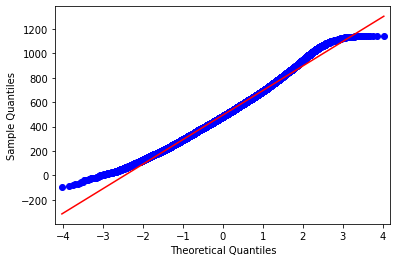

In [38]:
#We perform a qq plot then
sm.qqplot(df1d.x1, line='s')
pylab.show()

In [39]:
N = 200

In [40]:
df1d_sample = df1d.sample(N)

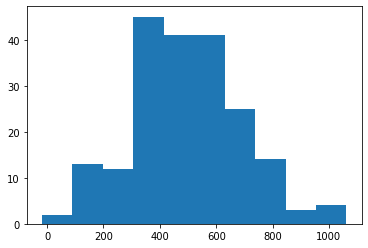

In [41]:
pyplot.hist(df1d_sample)
pyplot.show()

In [42]:
stats.shapiro(df1d_sample.x1)

ShapiroResult(statistic=0.9906617999076843, pvalue=0.2227771282196045)

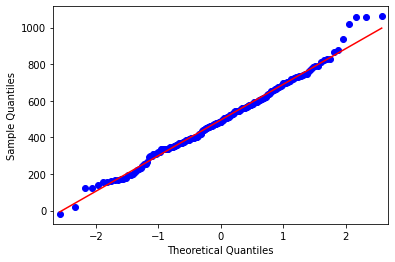

In [43]:
#We perform a qq plot then
sm.qqplot(df1d_sample.x1, line='s')
pylab.show()

In [44]:
# Henze-Zirkler Multivariate Normality Test
# multivariate_normality(df1d_sample)

## 2D 

In [45]:
df2d = dfs[1].rename(columns={'hw12':'x1', 'hw23':'x2'}, inplace = False)
df2d = df2d[['x1','x2']]

In [46]:
df2d_sample = df2d.sample(N)

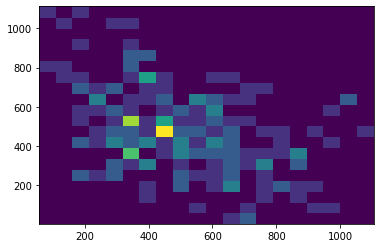

In [47]:
pyplot.hist2d(df2d_sample.x1,df2d_sample.x2, bins = 20)
pyplot.show()

In [48]:
# Henze-Zirkler Multivariate Normality Test
multivariate_normality(df2d_sample)

HZResults(hz=131.0086153598728, pval=2.784237889514156e-62, normal=False)

In [49]:
from scipy.stats import pearsonr
corr , _ = pearsonr(df2d_sample.x1,df2d_sample.x2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.431


## 3D

In [50]:
df3d = dfs[2].rename(columns={'hw12':'x1', 'hw23':'x2', 'hw34': 'x3'}, inplace = False)
df3d = df3d[['x1','x2','x3']]

In [51]:
df3d_sample = df3d.sample(N)
df3d_sample

x1   x2   x3
3239   447   30  652
3495   402  198  530
22882  287  506  595
22552  672  519  549
20162  697  238  636
...    ...  ...  ...
10843  881  175  523
5805   489  352  660
23132  579  496  668
6435   300  218  560
18030   31  323  600

[200 rows x 3 columns]

In [52]:
# Henze-Zirkler Multivariate Normality Test
multivariate_normality(df3d_sample)

HZResults(hz=155.56430911097456, pval=4.320743124145348e-187, normal=False)

## Cross-validation Results

In [96]:
n_folds = 3
results = cross_validate(n_folds,dfs)

In [97]:
results[(results.dim==2)&(results.conf==0.95)]

dim fold  n_slices  conf  size_th  anoms_detected  mean_size  max_size  \
30    2  1/3      9880  0.95        1             190      3.332        26   
31    2  1/3      9880  0.95        2             101      5.386        26   
32    2  1/3      9880  0.95        3              71      6.817        26   
39    2  2/3      9880  0.95        1             174      2.891        35   
40    2  2/3      9880  0.95        2              80      5.112        35   
41    2  2/3      9880  0.95        3              55      6.527        35   
48    2  3/3      9880  0.95        1             188      2.787        18   
49    2  3/3      9880  0.95        2              89      4.775        18   
50    2  3/3      9880  0.95        3              60      6.117        18   

    min_size  anom_percent  
30         1         6.408  
31         2         5.506  
32         3         4.899  
39         1         5.091  
40         2         4.139  
41         3         3.633  
48         1         5.303  
49         2         4.301  
50         3         3.715

In [112]:
def joint_cross_validation_results(cv_results,dim) :
    cv_results = cv_results[cv_results.dim==dim]
    confs = cv_results.conf.unique()
    size_ths = cv_results.size_th.unique()
    
    rows = []
    for conf in confs : 
        for size_th in size_ths :
            cv_res_conf = cv_results[(cv_results.conf == conf) & (cv_results.size_th == size_th)]
            
            n_slices = cv_res_conf.n_slices.sum()
            anoms_det = cv_res_conf.anoms_detected.sum()
            mean_size = cv_res_conf.mean_size.mean()
            max_size = cv_res_conf.max_size.max()
            anom_percent = mean_size*anoms_det*100/n_slices

            row = {}
            row['dim'] = dim
            row['folds'] = cv_res_conf.shape[0]
            row['n_slices'] = cv_res_conf.n_slices.sum()
            row['conf'] = conf
            row['size_th'] = size_th
            row['anoms_detected'] = anoms_det
            row['mean_size'] = mean_size
            row['max_size'] = max_size
            row['anom_percent'] = anom_percent
            
            rows.append(row)
            
    return pd.DataFrame(rows)

In [115]:
joint_cross_validation_results(results,1)

dim  folds  n_slices  conf  size_th  anoms_detected  mean_size  max_size  \
0    1      3     34950  0.90        1            1105      3.047        34   
1    1      3     34950  0.90        2             514      5.336        34   
2    1      3     34950  0.90        3             345      6.938        34   
3    1      3     34950  0.95        1             572      2.965        30   
4    1      3     34950  0.95        2             261      5.287        30   
5    1      3     34950  0.95        3             173      6.961        30   
6    1      3     34950  0.99        1             176      2.230        14   
7    1      3     34950  0.99        2              73      3.999        14   
8    1      3     34950  0.99        3              45      5.194        14   

   anom_percent  
0         9.635  
1         7.847  
2         6.849  
3         4.853  
4         3.948  
5         3.446  
6         1.123  
7         0.835  
8         0.669

## Train Models Parameters

In [38]:
#Get models parameters
cov_matrixes,means = get_model_params(dfs[0:3])

In [39]:
cov_matrixes

[201.45741558933028,
 array([[ 40766.5312355 , -12801.3415954 ],
        [-12801.3415954 ,  38265.82197495]]),
 array([[ 40577.91895858, -12214.53351512,  -2601.939992  ],
        [-12214.53351512,  37975.66262737, -13411.27449839],
        [ -2601.939992  , -13411.27449839,  37543.70304595]])]

In [40]:
#Test models built performance

#HYPERPARAMETERS
#Number of consecutive values over Mahalanobis distance to consider we have an outlier
size_ths = [1,2,3]
#Confidence for each dimension
confs = [0.9,0.95,0.99]

#Run tests
results,anomalies_dfs = get_result(dfs[1],cov_matrixes,means,confs,size_ths)

In [58]:
# results[(results.dim.isin([2]))].drop(['min_size'],axis=1)

## 2D Test Results

In [41]:
#Represent anomalies with confidence ellipse (for 2D)
conf = 0.95
dim = 2
size_th = 1

In [42]:
anomalies_2d_df = anomalies_dfs[conf][dim][size_th]
max_anom_size = anomalies_2d_df.anom_size.max()
anoms_detected = anomalies_2d_df.anom_index.max() + 1
mean_size = round(anomalies_2d_df.drop_duplicates('anom_index').anom_size.mean(),3)

In [43]:
from branca.colormap import linear
colormap = linear.Reds_09.scale(-10,max_anom_size).to_step(max_anom_size+12)
colormap

In [44]:
# anomalies_2d_df.tail()

In [45]:
# Get a reduced sample of the data
data = dfs[1].sample(frac=1)

In [46]:
x, y = ellipse(means[1],cov_matrixes[1],conf)

In [48]:
#Create figure
fig = go.Figure()

'''
#Plot trace
fig.add_trace(go.Scatter(
    showlegend=False,
    x = data.hw12,
    y = data.hw23,
    mode = 'markers',
    marker = dict(
        color='blue',
        size=2
    )
))
'''

#Select buses group to see over time
for i in range(1,max_anom_size) :
    #Get series data
    anom_size_df = anomalies_2d_df.loc[anomalies_2d_df.anom_size == i]
    color = colormap(i)[0:7]
    k = 0
    for anom_index in anom_size_df.anom_index.unique().tolist() :
        anom_df = anom_size_df.loc[anom_size_df.anom_index == anom_index]
        #Plot trace
        fig.add_trace(go.Scatter(
            name='Anomaly of size = {}'.format(i),
            showlegend= True if k==0 else False,
            x = anom_df.hw12,
            y = anom_df.hw23,
            mode = 'lines+markers',
            line = dict(
                color = color,
                width = 1.5
            ),
            text = anom_df.datetime.dt.time
        ))
        k+=1



#Confidence ellipses
i = 0
for conf in [0.95] :
    x,y = ellipse(means[1],cov_matrixes[1],conf)
    fig.add_trace(go.Scatter(
        name='{}% Confidence Ellipse'.format(conf*100),
        x=x,
        y=y,
        mode='lines',
        line=dict(
            color = colors[i],
            width = 1.5
        )
    ))
    i += 1




#Update the layout
fig.update_layout(
    title='2D Headways inside line {}, in {} days from {}:00 to {}:00.'.format(line,day_type,st_hour,end_hour),
    height=800,
    width=800,
    showlegend=False,
    legend=dict(
        x=0.75,
        y=0.99,
        traceorder='normal',
        font=dict(
            size=12
        ),
    ),
    xaxis=dict(
        title='hw12',
        nticks=20,
        zerolinecolor='darkgrey'
    ),
    yaxis=dict(
        title='hw23',
        scaleanchor="x", 
        scaleratio=1,
        nticks=20,
        zerolinecolor='darkgrey'
    )
)
fig.show()

## 2D Time series

In [146]:
index = 125
hws_2d = dfs[1][index:index+500]#[(dfs[1].datetime > datetime.datetime(2020,1,27,10)) & (dfs[1].datetime < datetime.datetime(2020,1,28,11))]
hws_2d[0:20]

datetime     bus1     bus2     bus3  hw12  hw23
125 2021-01-11 10:05:27.300193800  SK20BBO  SK20AXU  SK20BBF   627   321
126 2021-01-11 10:05:27.300193800  SK20AZD  SK20AYP  SK20AZC   655   677
127 2021-01-11 10:05:27.300193800  SK20AXU  SK20BBF  SK20AYS   321   407
128 2021-01-11 10:05:57.287696400  SK20AYA  SK20BCX  SK20AXY   385   560
129 2021-01-11 10:05:57.287696400  SK20AYB  SK20BDE  SK20AYZ   305   485
130 2021-01-11 10:05:57.287696400  SK20BCX  SK20AXY  SK20BDO   560   300
131 2021-01-11 10:05:57.287696400  SK20BDE  SK20AYZ  SK20AXV   485   604
132 2021-01-11 10:05:57.287696400  SK20AXY  SK20BDO  SK20BBO   300   690
133 2021-01-11 10:05:57.287696400  SK20AYZ  SK20AXV  SK20AZD   604   200
134 2021-01-11 10:05:57.287696400  SK20BDO  SK20BBO  SK20AXU   690   628
135 2021-01-11 10:05:57.287696400  SK20AXV  SK20AZD  SK20AYP   200   686
136 2021-01-11 10:05:57.287696400  SK20BBO  SK20AXU  SK20BBF   628   313
137 2021-01-11 10:05:57.287696400  SK20AZD  SK20AYP  SK20AZC   686   690
138 2021-01-11 10:05:57.287696400  SK20AXU  SK20BBF  SK20AYS   313   394
139 2021-01-11 10:06:27.307061800  SK20AYA  SK20BCX  SK20AXY   384   561
140 2021-01-11 10:06:27.307061800  SK20AYB  SK20BDE  SK20AYZ   290   443
141 2021-01-11 10:06:27.307061800  SK20BCX  SK20AXY  SK20BDO   561   138
142 2021-01-11 10:06:27.307061800  SK20BDE  SK20AYZ  SK20AXV   443   726
143 2021-01-11 10:06:27.307061800  SK20AXY  SK20BDO  SK20BBO   138   886
144 2021-01-11 10:06:27.307061800  SK20AYZ  SK20AXV  SK20AZD   726   138

In [147]:
busA_1 = hws_2d.iloc[index].bus1
busB_1 = hws_2d.iloc[index].bus2
busC_1 = hws_2d.iloc[index].bus3

busA_2 = hws_2d.iloc[index+1].bus1
busB_2 = hws_2d.iloc[index+1].bus2
busC_2 = hws_2d.iloc[index+1].bus3

busA_3 = hws_2d.iloc[index+2].bus1
busB_3 = hws_2d.iloc[index+2].bus2
busC_3 = hws_2d.iloc[index+2].bus3

busA_4 = hws_2d.iloc[index+3].bus1
busB_4 = hws_2d.iloc[index+3].bus2
busC_4 = hws_2d.iloc[index+3].bus3


#b1,b2,b3,b4,b5 = 119,118,8238,116,121

#hw_AB1 = hws.loc[(hws.busA==b1)&(hws.busB==b2)]
#hw_AB2 = hws.loc[(hws.busA==b2)&(hws.busB==b3)]
#hw_AB3 = hws.loc[(hws.busA==b3)&(hws.busB==b4)]

#hw_AB4 = hws.loc[(hws.busA==b4)&(hws.busB==b5)]
#hw_AB5 = hws.loc[(hws.busA==b3)&(hws.busB==b2)]

hw_ABC1 = hws_2d.loc[(hws_2d.bus1==busA_1)&(hws_2d.bus2==busB_1)&(hws_2d.bus3==busC_1)]
hw_ABC2 = hws_2d.loc[(hws_2d.bus1==busA_2)&(hws_2d.bus2==busB_2)&(hws_2d.bus3==busC_2)]
hw_ABC3 = hws_2d.loc[(hws_2d.bus1==busA_3)&(hws_2d.bus2==busB_3)&(hws_2d.bus3==busC_3)]
hw_ABC4 = hws_2d.loc[(hws_2d.bus1==busA_4)&(hws_2d.bus2==busB_4)&(hws_2d.bus3==busC_4)]

hw_ABC1.iloc[0:10]

datetime     bus1     bus2     bus3  hw12  hw23
133 2021-01-11 10:05:57.287696400  SK20AYZ  SK20AXV  SK20AZD   604   200
144 2021-01-11 10:06:27.307061800  SK20AYZ  SK20AXV  SK20AZD   726   138
155 2021-01-11 10:06:57.315268400  SK20AYZ  SK20AXV  SK20AZD   674   178
166 2021-01-11 10:07:27.223278900  SK20AYZ  SK20AXV  SK20AZD   636   157
178 2021-01-11 10:07:57.219910500  SK20AYZ  SK20AXV  SK20AZD   613   254
190 2021-01-11 10:08:27.187102500  SK20AYZ  SK20AXV  SK20AZD   294   557
202 2021-01-11 10:08:57.233836700  SK20AYZ  SK20AXV  SK20AZD   257   557
214 2021-01-11 10:09:27.201736200  SK20AYZ  SK20AXV  SK20AZD   440   410
226 2021-01-11 10:09:55.574494400  SK20AYZ  SK20AXV  SK20AZD   439   379
238 2021-01-11 10:10:27.197300900  SK20AYZ  SK20AXV  SK20AZD   518   301

In [148]:
#Create figure
fig = go.Figure()

hw_ABCs = [hw_ABC1,hw_ABC2,hw_ABC3,hw_ABC4]
for k in range(len(hw_ABCs)) :
    hw_ABC = hw_ABCs[k]
    #Separate fragments
    hw_ABC_splits = []
    last_index = 0
    last_time = hw_ABC.iloc[0].datetime
    nsplits = 0
    for i in range(hw_ABC.shape[0]) :
        if ((hw_ABC.iloc[i].datetime - last_time).total_seconds() > 500) | ((i+1) == hw_ABC.shape[0]):
            split = hw_ABC.iloc[last_index:i]
            nsplits += 1
            if split.shape[0] < 1 :
                continue
            last_index = i
            
            fig.add_trace(go.Scatter(
                showlegend=False,
                x = [split.hw12.iloc[-1]],
                y = [split.hw23.iloc[-1]],
                mode = 'markers',
                marker = dict(
                    color = 'black',
                    size = 10
                )
            ))
            
            fig.add_trace(go.Scatter(
                name = '{}-{}-{}'.format(split.iloc[0].bus1,split.iloc[0].bus2,split.iloc[0].bus3),
                showlegend=(nsplits==1),
                x = split.hw12,
                y = split.hw23,
                mode = 'lines+markers',
                line = dict(
                    color = colors[k],
                    width = 1.5
                )
            ))
            
        last_time = hw_ABC.iloc[i].datetime
        
#Update the layout
fig.update_layout(
    height=800,
    width=800,
    legend=dict(
        title='<b>Buses group',
        x=0.7,
        y=0.99,
        traceorder='normal',
        font=dict(
            size=12
        ),
    ),
    xaxis=dict(
        title='hw12',
        nticks=20,
        zerolinecolor='darkgrey'
    ),
    yaxis=dict(
        title='hw23',
        scaleanchor="x", 
        scaleratio=1,
        nticks=20,
        zerolinecolor='darkgrey'
    )
)
fig.show()

## Get data outside confidence region

In [43]:
#Get Mahalanobis distance squared from which a certain percentage of the data is out
m_th = math.sqrt(chi2.ppf(conf, df=dim))
m_th

2.447746830680816

In [44]:
data.head()

datetime     bus1     bus2     bus3  hw12  hw23
133   2021-01-11 07:06:57.612484700  SK20AYP  SK20AZC  SK20AZJ   524   483
2883  2021-01-12 07:14:15.889364400  SK20AYL  SK20AYG  SK20BCO   181   632
37120 2021-01-28 08:31:04.045689200  SK20BBN  SK20AYZ  SK20BCU   723   435
25372 2021-01-22 07:44:22.140012600  SK20BCV  SK20AXX  SK20AXZ   798   188
46713 2021-02-03 08:00:44.772815000  SK20BBN  SK20BDF  SK20AXX   765   104

In [45]:
#Calculate mahalanobis distance for each point of the group
m_dists = []
hw_names = ['hw' + str(i) + str(i+1) for i in range(1,dim+1)]
mean = means[dim-1]
cov_matrix = cov_matrixes[dim-1]
#Inverse of cov matrix
if dim > 1:
    iv = np.linalg.inv(cov_matrix)
else :
    std = cov_matrix
    
for i in range(data.shape[0]) :
    hws = data.iloc[i][hw_names]
    if dim > 1 :
        m_dist = mahalanobis(mean, hws, iv)
    else :
        std = cov_matrix
        hw_val = hws[0]
        m_dist = np.abs(mean - hw_val)/std
    m_dists.append(m_dist)

In [46]:
data['m_dist'] = m_dists

In [47]:
# Remove instances inside confidence region
data = data[data.m_dist >= m_th]

In [48]:
#Create figure
fig = go.Figure()

#Plot trace
fig.add_trace(go.Scatter(
    showlegend=False,
    x = data.hw12,
    y = data.hw23,
    mode = 'markers',
    marker = dict(
        color='blue',
        size=1
    )
))

'''
#Select buses group to see over time
for i in range(1,max_anom_size) :
    #Get series data
    anom_size_df = anomalies_2d_df.loc[anomalies_2d_df.anom_size == i]
    color = colormap(i)[0:7]
    k = 0
    for anom_index in anom_size_df.anom_index.unique().tolist() :
        anom_df = anom_size_df.loc[anom_size_df.anom_index == anom_index]
        #Plot trace
        fig.add_trace(go.Scatter(
            name='Anomaly of size = {}'.format(i),
            showlegend= True if k==0 else False,
            x = anom_df.hw12,
            y = anom_df.hw23,
            mode = 'lines+markers',
            line = dict(
                color = color,
                width = 1.5
            ),
            text = anom_df.datetime.dt.time
        ))
        k+=1
'''




#Confidence ellipse
x,y = ellipse(means[1],cov_matrixes[1],conf)
fig.add_trace(go.Scatter(
    name='{}% Confidence Ellipse'.format(conf*100),
    x=x,
    y=y,
    mode='lines',
    line=dict(
        color = colors[3],
        width = 2.5
    )
))



#Update the layout
fig.update_layout(
    title='2D Headways inside line {}, in {} days from {}:00 to {}:00. Points outside confidence region.'.format(line,day_type,st_hour,end_hour),
    height=800,
    width=800,
    legend=dict(
        x=0.75,
        y=0.99,
        traceorder='normal',
        font=dict(
            size=12
        ),
    ),
    xaxis=dict(
        title='hw12',
        nticks=20,
        zerolinecolor='darkgrey'
    ),
    yaxis=dict(
        title='hw23',
        scaleanchor="x", 
        scaleratio=1,
        nticks=20,
        zerolinecolor='darkgrey'
    )
)
fig.show()

# Clustering

In [49]:
import sklearn
import numpy

## Affinity Propagation

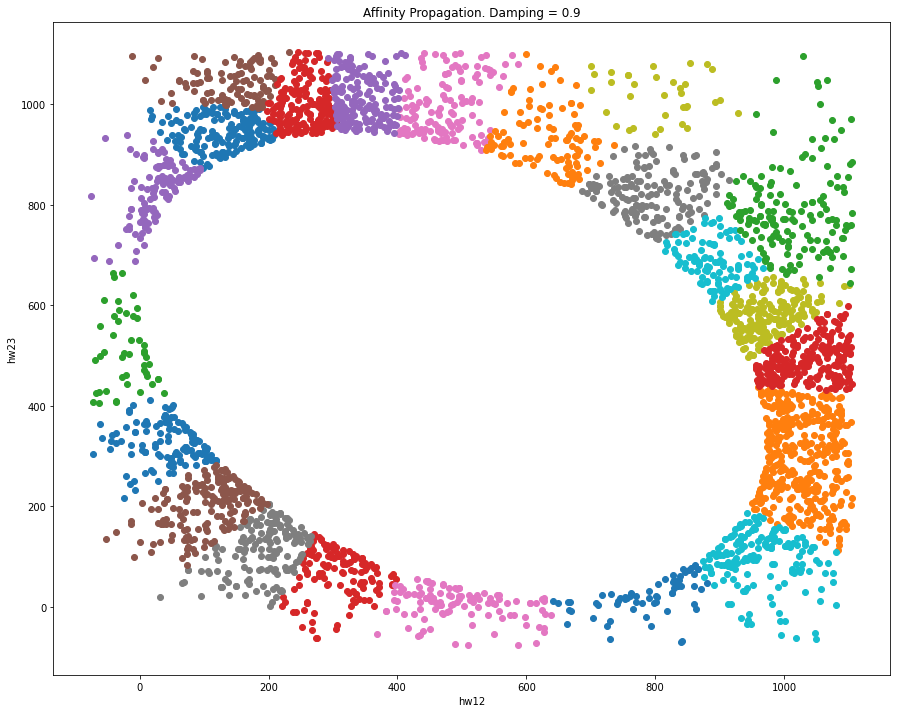

In [50]:
from numpy import where
from numpy import unique
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation

plt.figure(figsize=(15,12))

# Data
features = data[['hw' + str(i) + str(i+1) for i in range(1,3)]]
X = features.values

# Model
damping = 0.9
model = AffinityPropagation(damping = damping, random_state = None)

# Fit the model
model.fit(X)

# Assign a cluster to each example
yhat = model.predict(X)

# Retrieve unique clusters and create plot
clusters = unique(yhat)
for cluster in clusters :
    row_ix = where(yhat == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
    
# Add title and axis names
plt.title('Affinity Propagation. Damping = {}'.format(damping))
plt.xlabel('hw12')
plt.ylabel('hw23')

#Show the plot 
plt.show()

## DBSCAN

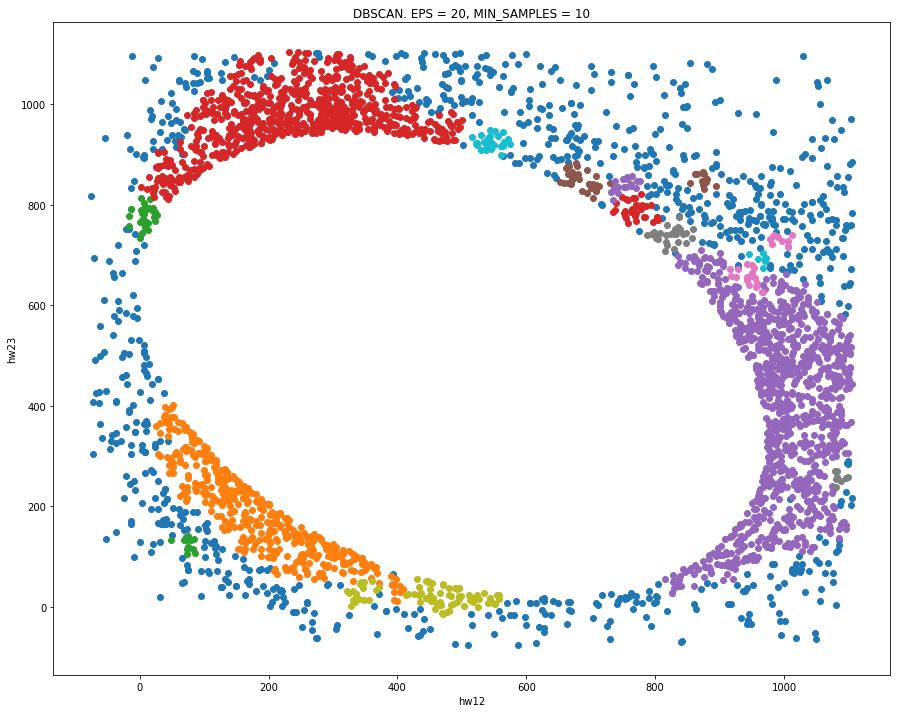

In [51]:
from sklearn.cluster import DBSCAN

plt.figure(figsize=(15,12))

eps = 20
min_samples = 10
model = DBSCAN(eps=eps, min_samples = min_samples)

yhat = model.fit_predict(X)
clusters = unique(yhat)
for cluster in clusters :
    row_ix = where(yhat == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

# Add title and axis names
plt.title('DBSCAN. EPS = {}, MIN_SAMPLES = {}'.format(eps,min_samples))
plt.xlabel('hw12')
plt.ylabel('hw23')

#Show the plot 
plt.show()

## K-Means

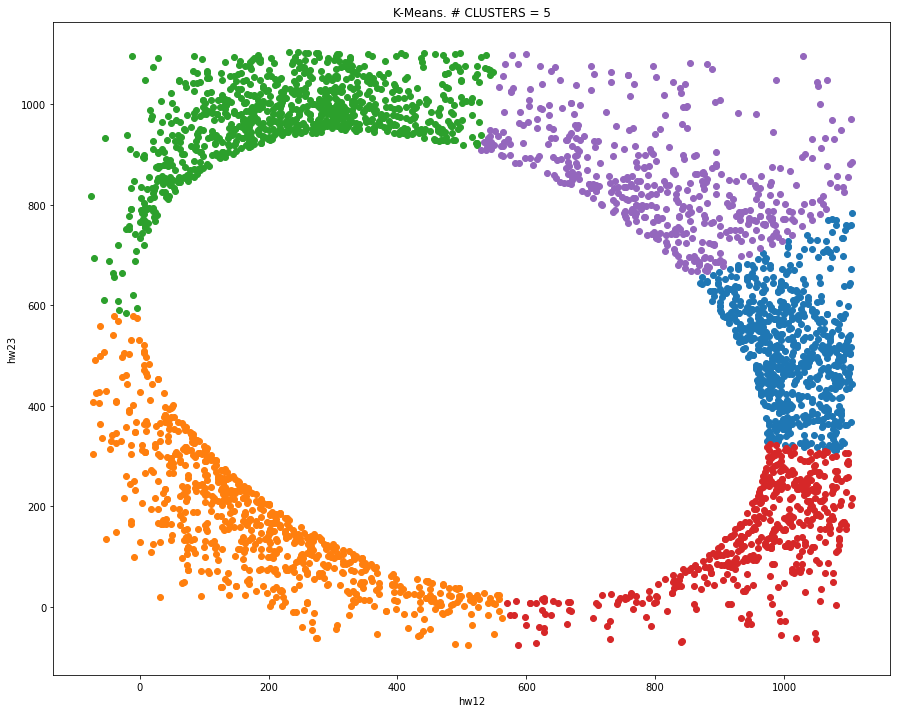

In [52]:
from sklearn.cluster import KMeans

plt.figure(figsize=(15,12))

n_clusters = 5
model = KMeans(n_clusters = n_clusters)

model.fit(X)
yhat = model.predict(X)

clusters = unique(yhat)
for cluster in clusters :
    row_ix = where(yhat == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

# Add title and axis names
plt.title('K-Means. # CLUSTERS = {}'.format(n_clusters))
plt.xlabel('hw12')
plt.ylabel('hw23')

#Show the plot 
plt.show()

## Aglomerative Hierarchical Clustering

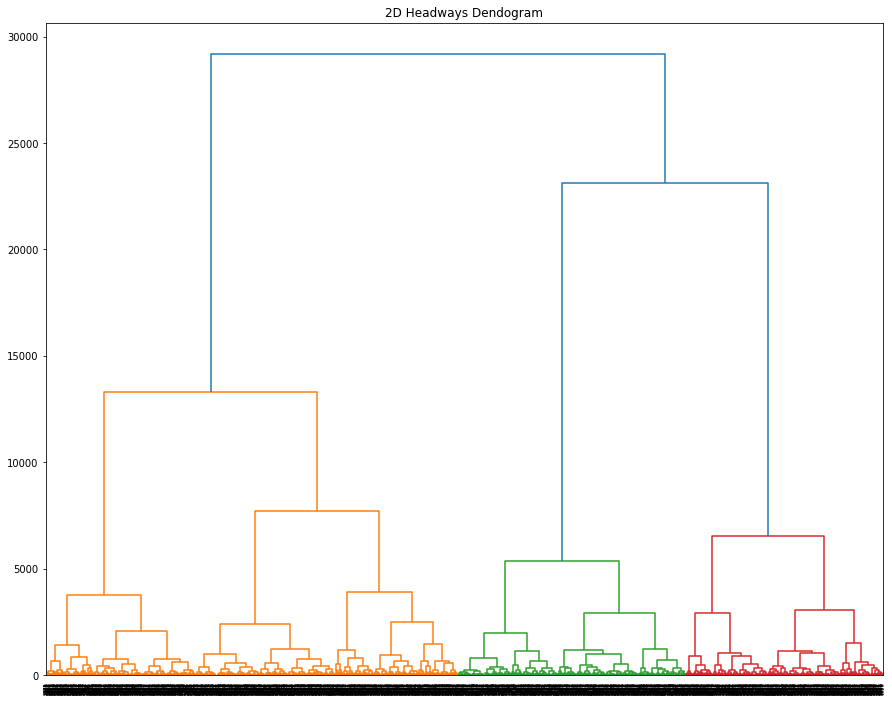

In [53]:
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 12))
plt.title("2D Headways Dendogram")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

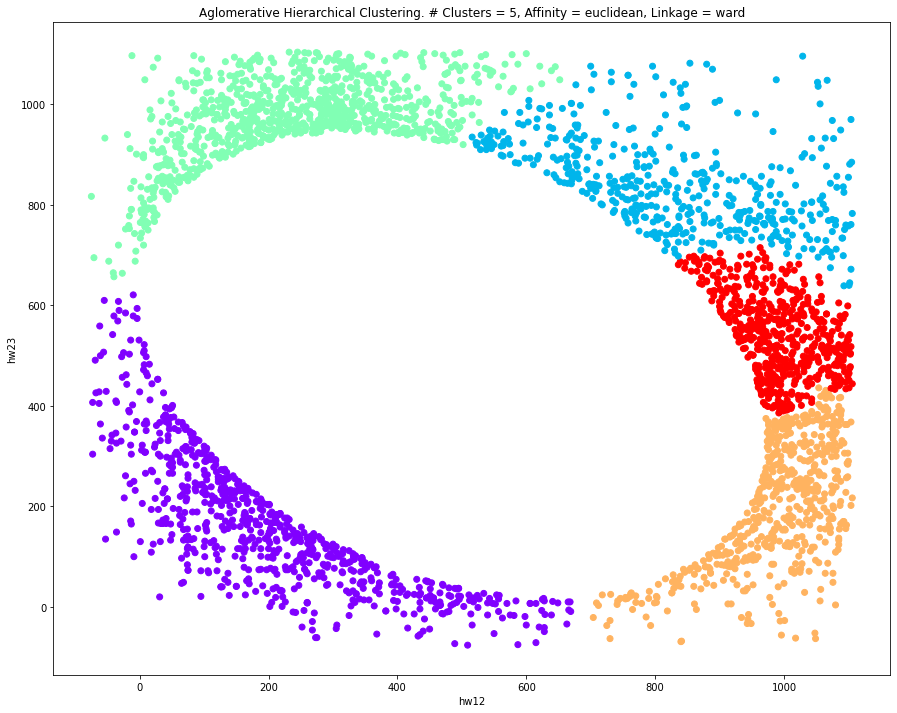

In [54]:
plt.figure(figsize=(15,12))

n_clusters = 5
affinity = 'euclidean' 
linkage = 'ward'
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
cluster.fit_predict(X)

# Add title and axis names
plt.title('Aglomerative Hierarchical Clustering. # Clusters = {}, Affinity = {}, Linkage = {}'.format(n_clusters,affinity,linkage))
plt.xlabel('hw12')
plt.ylabel('hw23')

plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')

## Self-Organizing Maps

In [55]:
import SimpSOM as sps

net = sps.somNet(20, 20, X, PBC=True)
net.train(0.01, 20000)

Periodic Boundary Conditions active.
The weights will be initialised randomly.
Training SOM... done!           


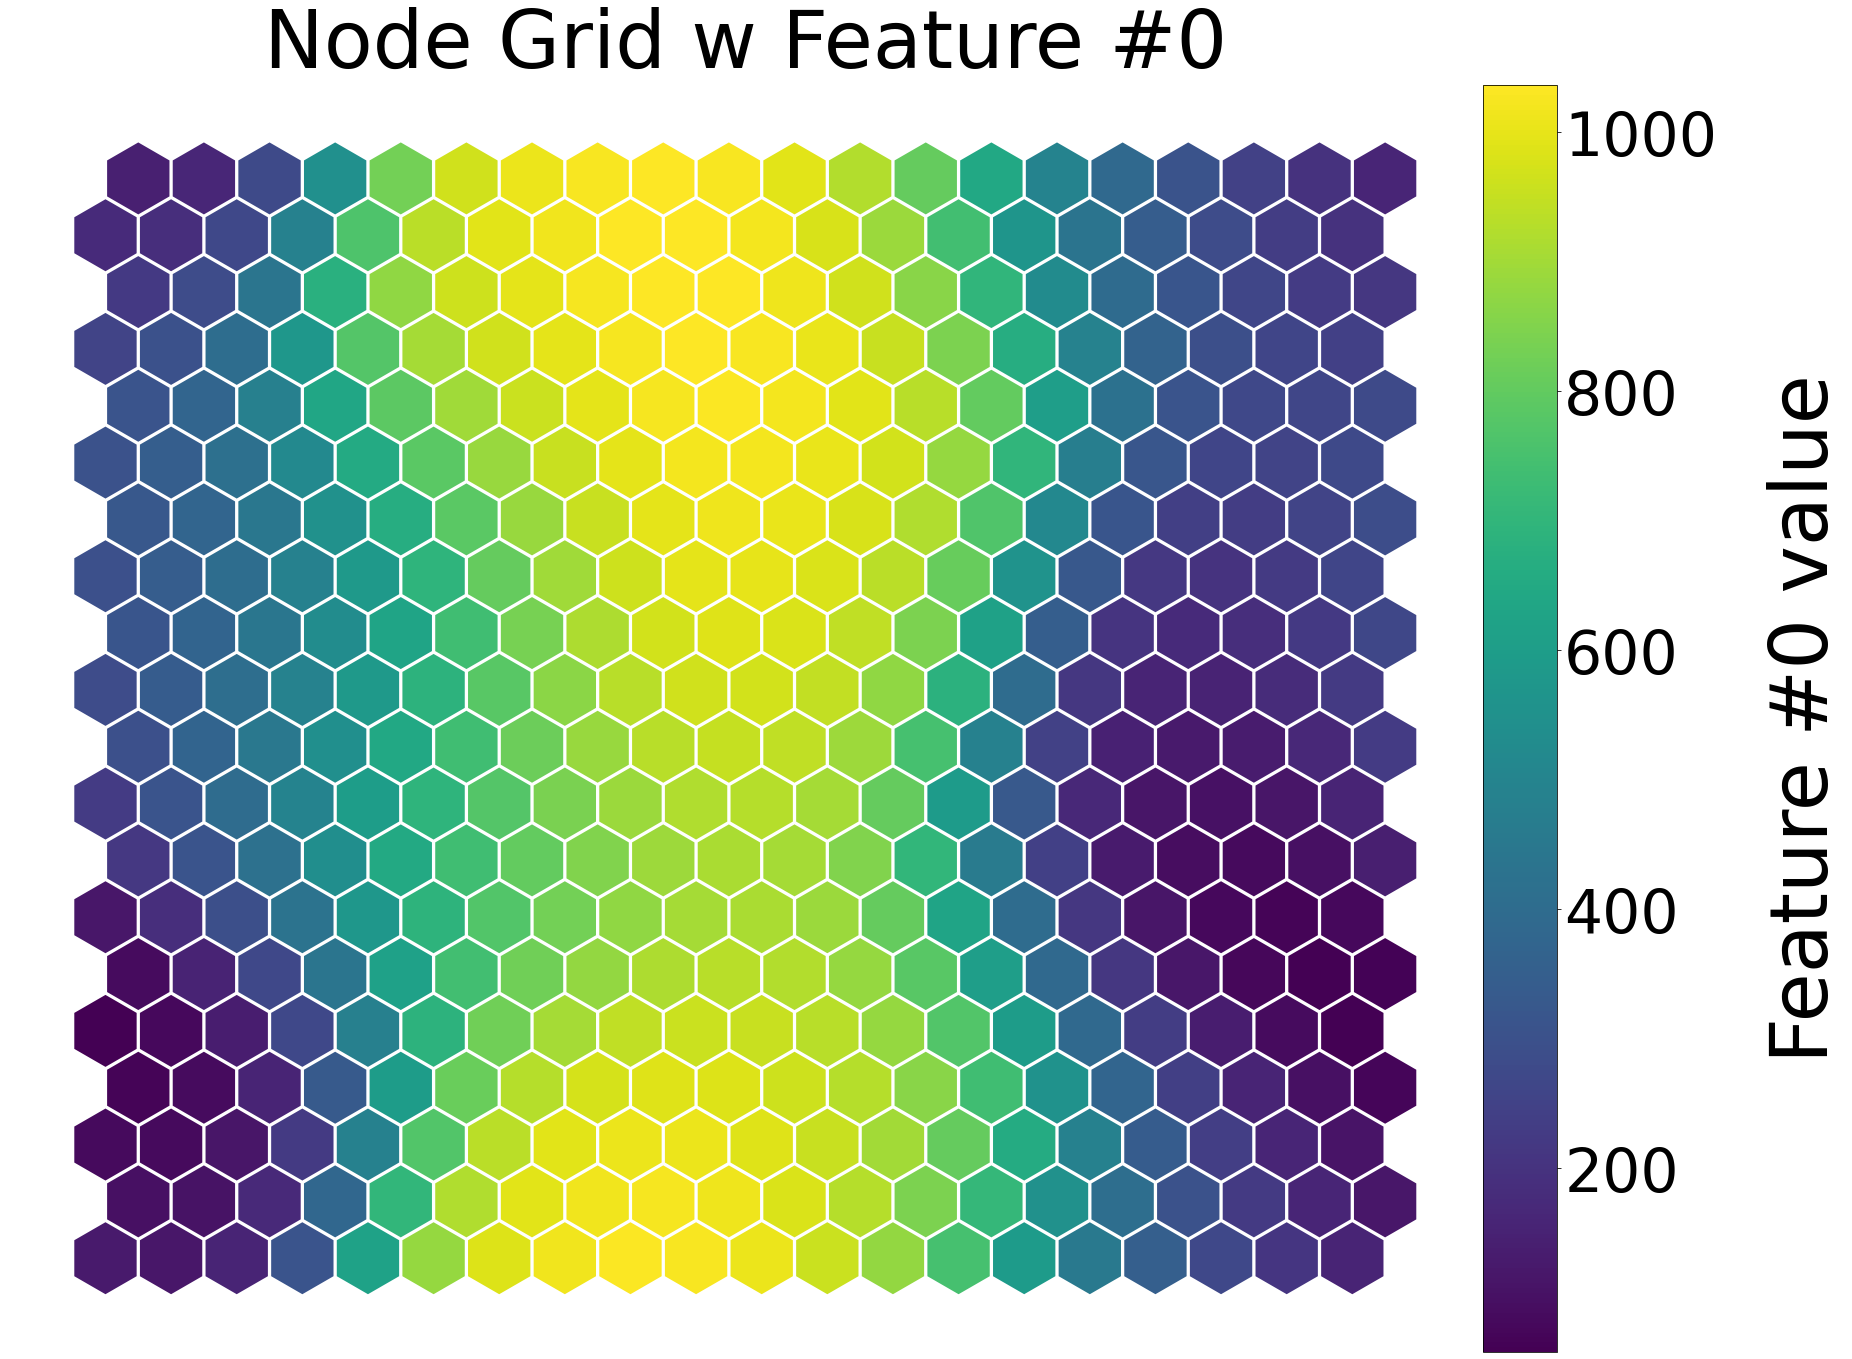

In [56]:
net.nodes_graph(colnum=0)

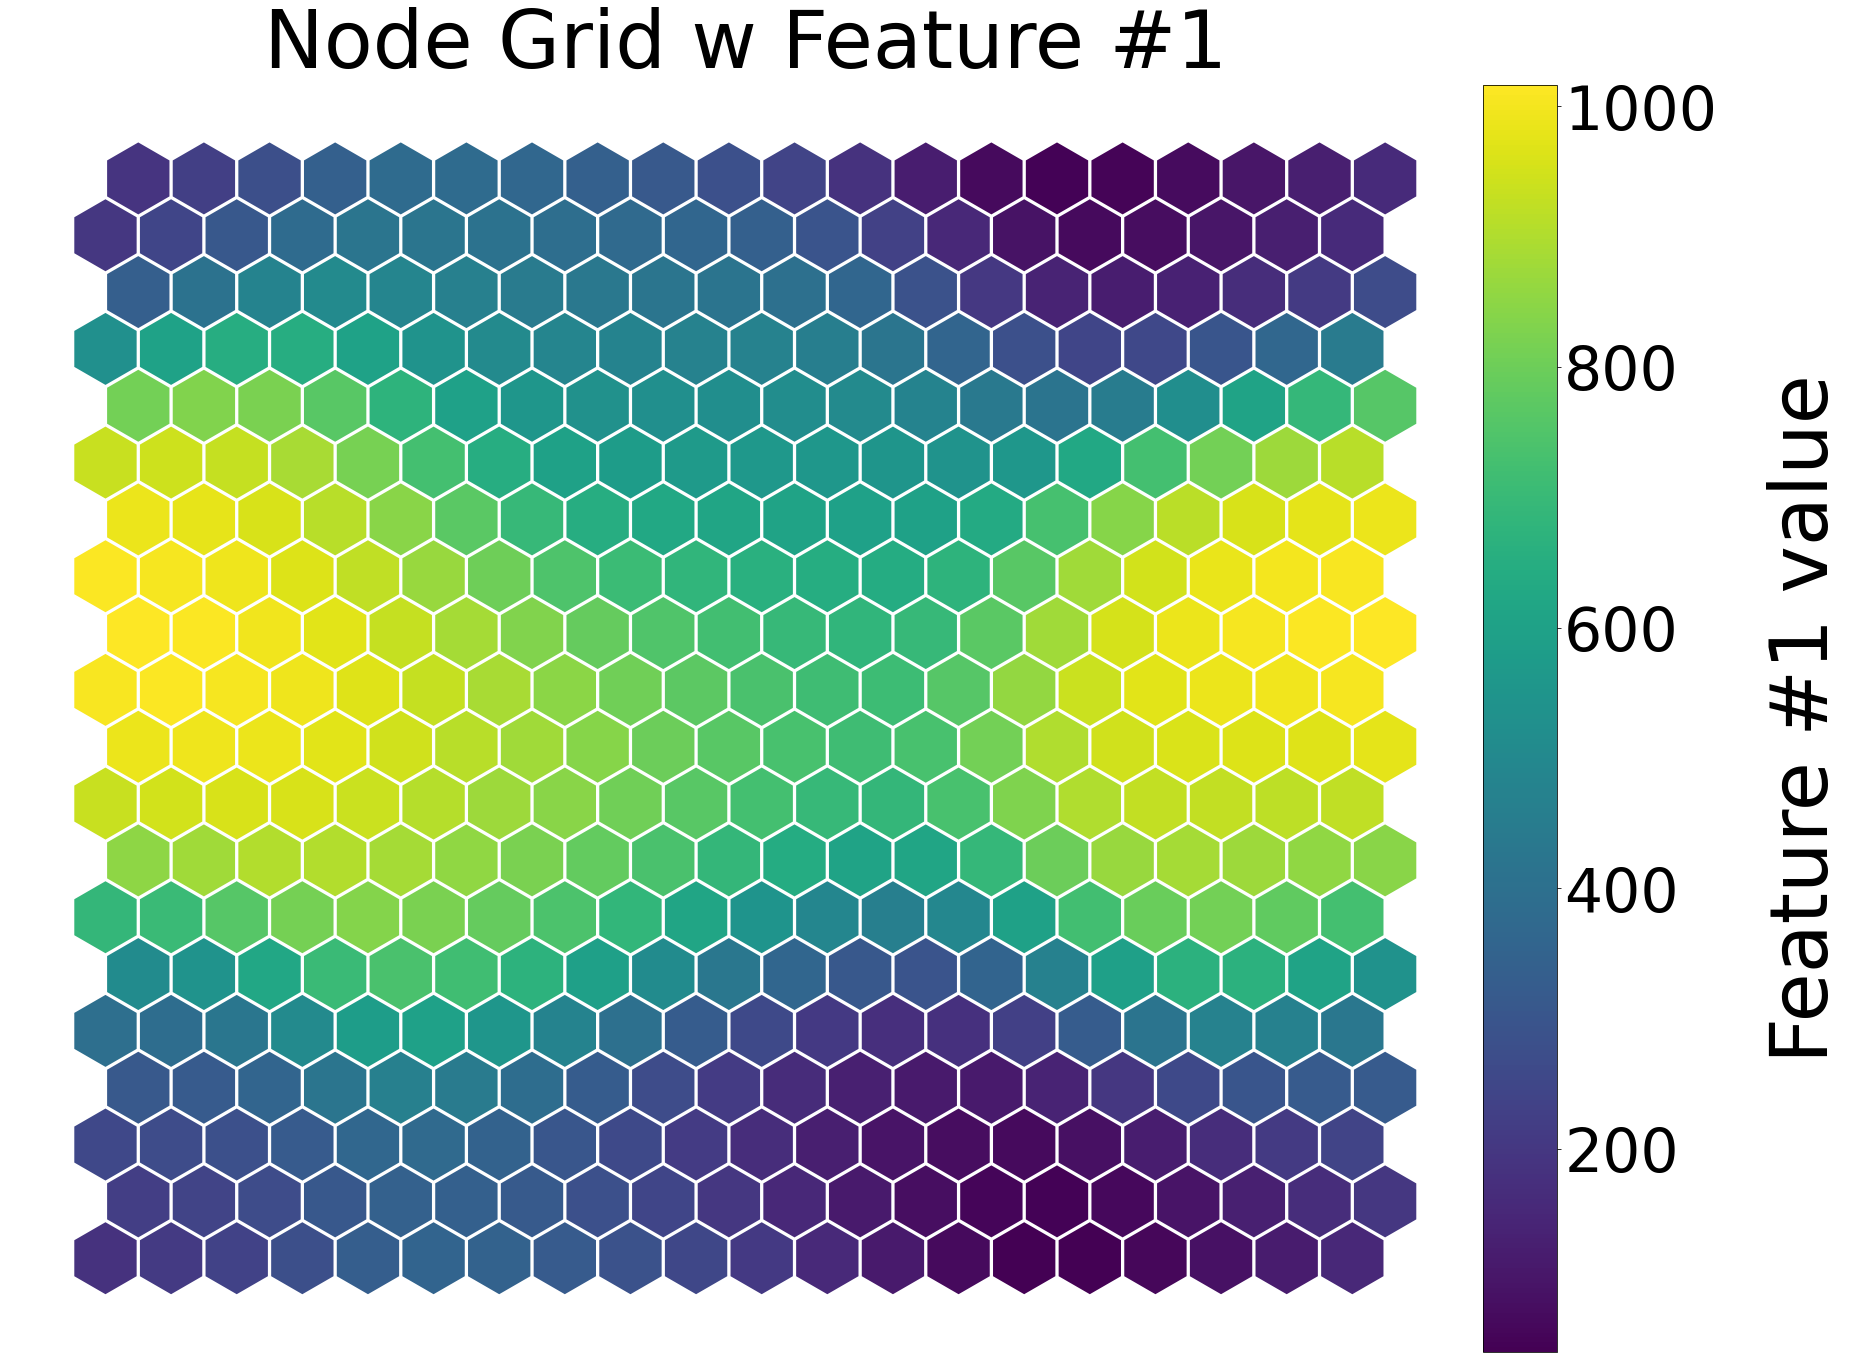

In [57]:
net.nodes_graph(colnum=1)

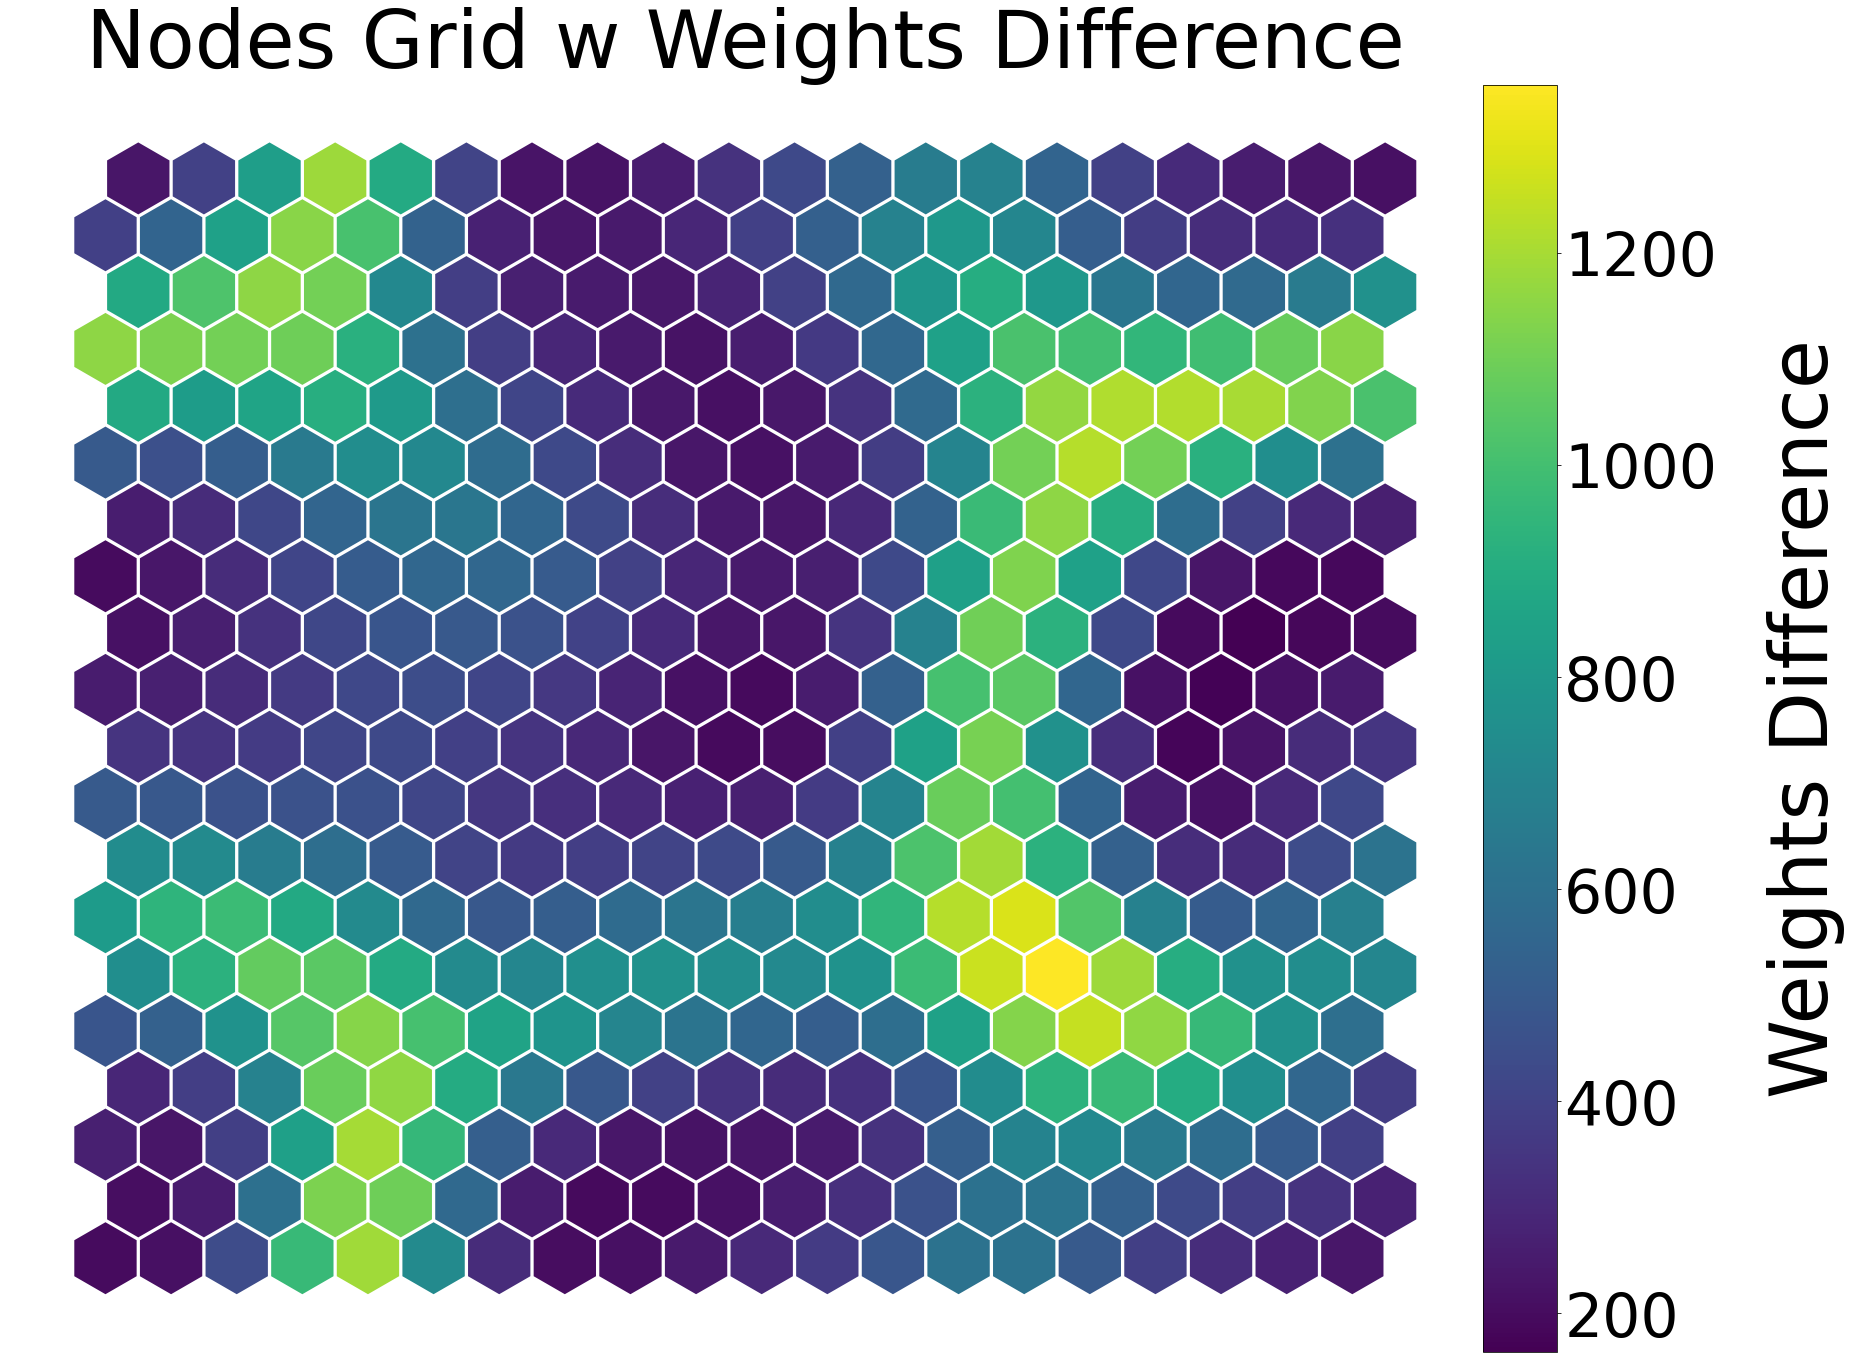

In [58]:
net.diff_graph()

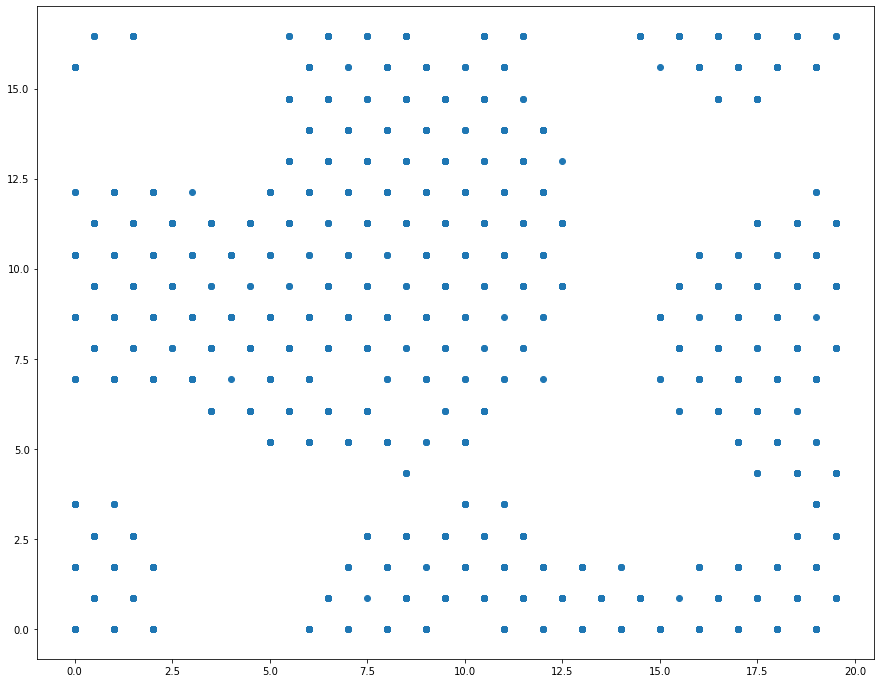

In [59]:
plt.figure(figsize=(15,12))
prj=np.array(net.project(X))
plt.scatter(prj.T[0],prj.T[1])
plt.show()